<a href="https://colab.research.google.com/github/pvss2A3/FD_YOLO-darknet/blob/main/FD_yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google Drive to Google Colab notebook**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/FD_dataset

/content/gdrive/MyDrive/FD_dataset


**Create the folder in which our yolo annotations will be saved**

In [ ]:
!mkdir mask_yolo_train

Run the py script that converts **.xml** files into **.txt** files, which are compatible for yolo.

> Indented block



-   --input  = [path_of_folder_with_xml_files]
-   --output = [path_of_folder_with_txt_files]

In [ ]:
!python yolo_xml_to_txt.py --input='/content/gdrive/MyDrive/FD_dataset/annotations' --output='/content/gdrive/MyDrive/FD_dataset/mask_yolo_train/'

python3: can't open file 'yolo_xml_to_txt.py': [Errno 2] No such file or directory


**Check:** Count how many items have been created (853 in our case)

In [3]:
!ls mask_yolo_train// -1 | wc -l

1534


Copy all the images from **images folder** into **mask_yolo_train folder**

In [ ]:
!cp -r /content/gdrive/MyDrive/FD_dataset/images/. mask_yolo_train

^C


At this point we have to split our data into **train and test** data.
I created one more folder: **mask_yolo_test** and I saved 86 of the images in this folder. Therest 767 images are going to be used for trainining

In [4]:
%cd mask_yolo_train
!ls -F | grep .png | wc -l
!ls -F | grep .txt | wc -l
%cd ..

%cd mask_yolo_test
!ls -F | grep .png | wc -l
!ls -F | grep .txt | wc -l
%cd ..

/content/gdrive/My Drive/FD_dataset/mask_yolo_train
767
767
/content/gdrive/My Drive/FD_dataset
/content/gdrive/My Drive/FD_dataset/mask_yolo_test
86
86
/content/gdrive/My Drive/FD_dataset


Create **train.txt** file and **test.txt** file which contain the absolute paths of each .txt annotation file of **mask_yolo_train** folder and **mask_yolo_test** folder, respectively

(These files are important for training and testing our yolo model)

In [5]:
import os

for dataset, txtname in zip(['mask_yolo_train/', 'mask_yolo_test/'], ['train.txt', 'test.txt']):
    image_files = []
    # Given we are already being located into /face_mask_detection folder
    os.chdir(os.path.abspath(dataset))
    count=0
    for filename in os.listdir(os.getcwd()):
      if filename.endswith(".png"):
          image_files.append(os.path.abspath(os.getcwd()) + '/' + filename)

    os.chdir("..")
    with open(txtname, "w") as outfile:
        for image in image_files:
            outfile.write(image)
            outfile.write("\n")
        outfile.close()

Change directory, go to the parent directory (MyDrive) and there clone darknet from AlexeyAB's repo

In [ ]:
!cp train.txt ../darknet/data
!cp test.txt ../darknet/data

In [6]:
%cd ..
!git clone https://github.com/AlexeyAB/darknet
%cd darknet

/content/gdrive/My Drive
fatal: destination path 'darknet' already exists and is not an empty directory.
/content/gdrive/My Drive/darknet


Check the **GPU**

In [7]:
!nvidia-smi

Fri Jul  9 22:24:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Modify Makefile in order to activate GPUs configuration

In [47]:
# change makefile to have GPU, OPENCV and LIBSO enabled
!sed -i 's/OPENCV=0/OPENCV=1' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
!sed -i 's/ZED camera=0/ZED camera=1/' Makefile

!/usr/local/cuda/bin/nvcc --version

sed: -e expression #1, char 19: unterminated `s' command
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


Compile our source files

In [48]:
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_opencv.cpp:1150:10: note: 

Get the weights of pretrained yolov3 model with 53 conv layers

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2021-07-09 09:29:02--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  80.8MB/s    in 2.9s    

2021-07-09 09:29:05 (80.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2021-07-09 09:29:05--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.1’

darknet53.conv.74.1 100%[===================>] 154.96M  79.5MB/s    in 1.9s    

2021-07-09 09:29:07 (79.5 MB/s) - ‘darknet53.conv.74.1’ saved [162482580/162482580]



Change permissions

In [10]:
!chmod +x ./darknet

- Copy *train.txt* file from **face_mask_detection/** folder to **darknet/data/** folder

- Create *face_mask.names* file, which contains the categories of our detection task. ***Good*** if someone wears properly her/his mask) ***Bad*** if someone doesn't wear a mask or wears it incorrectly

- Create *face_mask.data* file

- Create *face_mask.cfg* file and modify it so as to meet our task's criteria. For full details: https://github.com/AlexeyAB/darknet

- Finally, **darknet/data/** folder should contain: *train.txt, face_mask.data, face_mask.names*, while **darknet/cfg/** should contain *face_mask.cfg*

Execution command for training

In [11]:
#!./darknet detector train data/face_mask.data cfg/face_mask.cfg backup/face_mask_last.weights -dont_show -i 0 -map -points 0

!./darknet detector train data/face_mask.data cfg/face_mask.cfg darknet53.conv.74.1 -dont_show -i 0 -map -points 0

Streaming output truncated to the last 5000 lines.
 total_bbox = 1827214, rewritten_bbox = 0.036175 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.710638), count: 3, class_loss = 0.029073, iou_loss = 0.281763, total_loss = 0.310836 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000006, iou_loss = 0.000000, total_loss = 0.000006 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.741934), count: 2, class_loss = 0.076012, iou_loss = 0.124743, total_loss = 0.200754 
 total_bbox = 1827219, rewritten_bbox = 0.036175 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.795675), count: 3, class_loss = 0.056071, iou_loss = 0.084919, total_loss = 0.140990 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.841320), count: 8, class_loss = 0.326642, iou_loss = 0.121495, total_loss = 0.448137 
v3 (

**Check** the mAP0.5 of the best weights. **(85.97%)**

In [41]:
!./darknet detector map data/face_mask.data cfg/face_mask.cfg /content/gdrive/MyDrive/FD_dataset/backup/face_mask_best.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcu

Execution command for testing

In [55]:
!./darknet detector test data/face_mask.data cfg/face_mask.cfg /content/gdrive/MyDrive/FD_dataset/backup/face_mask_best.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcu

Auxiliary function for displaying on Colab our prediction.jpg image

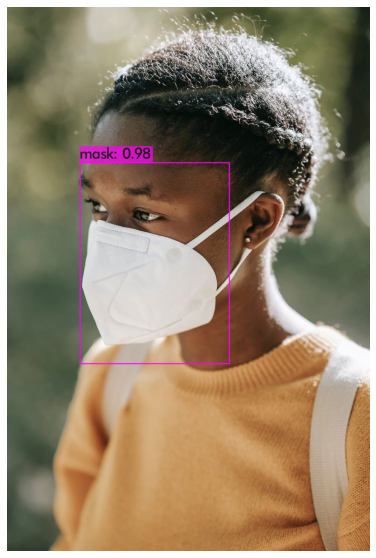

In [56]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

imShow('/content/gdrive/MyDrive/darknet/predictions.jpg')

In [57]:
!./darknet detector test data/face_mask.data cfg/face_mask.cfg /content/gdrive/MyDrive/FD_dataset/backup/face_mask_best.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcu

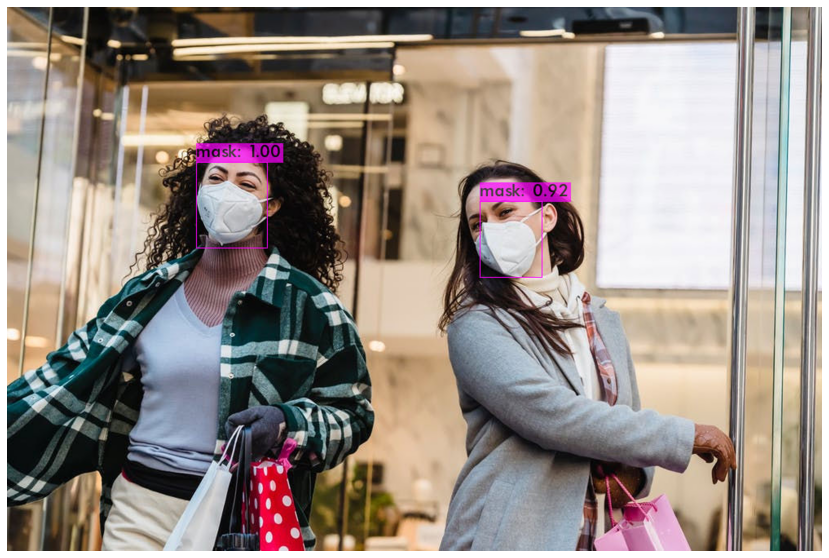

In [58]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

imShow('/content/gdrive/MyDrive/darknet/predictions.jpg')

In [59]:
!./darknet detector test data/face_mask.data cfg/face_mask.cfg /content/gdrive/MyDrive/FD_dataset/backup/face_mask_best.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcu

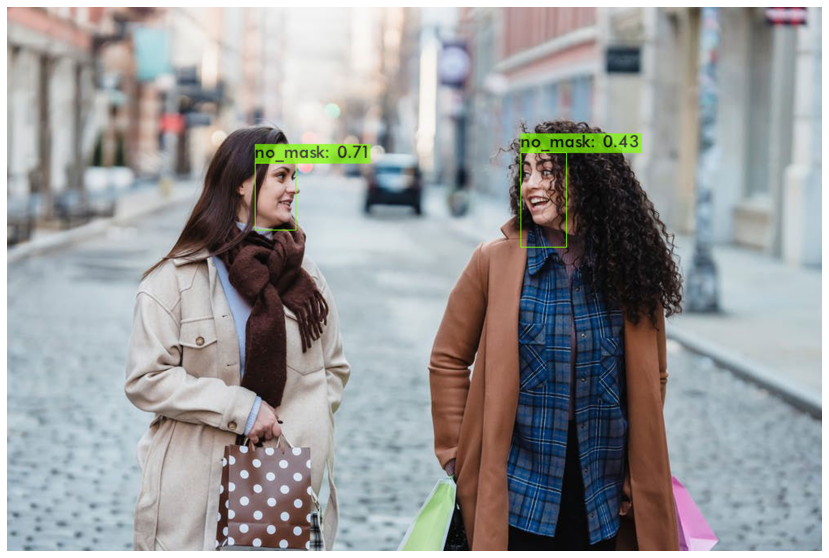

In [60]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

imShow('/content/gdrive/MyDrive/darknet/predictions.jpg')

In [63]:
!./darknet detector test data/face_mask.data cfg/face_mask.cfg /content/gdrive/MyDrive/FD_dataset/backup/face_mask_best.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcu

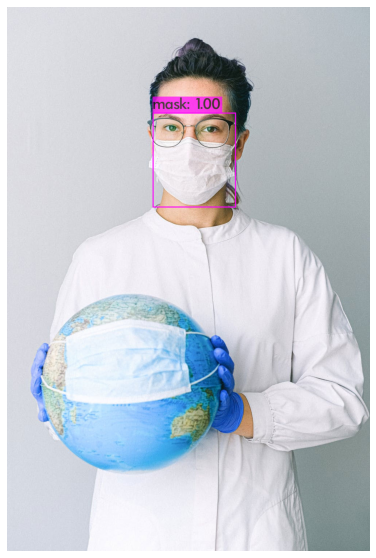

In [64]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

imShow('/content/gdrive/MyDrive/darknet/predictions.jpg')